# Modelo para predicción NO2 en Barcelona

## Preprocesamiento, evaluación de algoritmos, construcción de modelo de predicción

Realizamos primero un estudio completo cargando el dataset mergeado trabajado con selección de 5 características, y después lo repetiremos con los datos sin selección de características para comparar.

In [1]:
#Importamos las librerías que vamos a usar para los distintos pasos del problema

import numpy as np
import pandas as pd
from numpy import set_printoptions
#Visualización
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
#Preprocesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import Binarizer
#Remuestreo
from sklearn.model_selection import train_test_split;
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
#Algoritmos de Regresión Lineal
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
#Algoritmos de Regresión No Lineal
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
#Métricas de evaluación de algoritmos
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#Ensamblamiento Regresión
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
#Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
#Pipelines
from sklearn.pipeline import Pipeline
#Metricas
from sklearn.metrics import mean_squared_error
#Serializar (guardar y cerrar modelo)
from joblib import dump


## 1) Carga del dataset mergeado trabajado CON selección de características para NO2

In [2]:
#cogemos el dataset trabajado anteriormente con los datos mergeados y habiendo hecho una reducción de variables
url_fichero_mercscno2 = './DatosMergeadosBarcelona_ConSeleccionCaract_ParaNO2.csv'
dfMergeadoSelCaractNO2 = pd.read_csv(url_fichero_mercscno2)
dfMergeadoSelCaractNO2 = dfMergeadoSelCaractNO2.set_index('date')
print(dfMergeadoSelCaractNO2.columns)
print(dfMergeadoSelCaractNO2)

Index(['no2', 'year', 'month', 'day', 'tmed', 'velmedia', 'racha', 'presmax',
       'week', 'season', 'season_name', 'estado_trafico', 'diadelasemana',
       'findesemana'],
      dtype='object')
                  no2  year  month  day  tmed  velmedia  racha  presmax  week  \
date                                                                            
2018-01-01  24.000000  2018      1    1  12.8       4.2   18.1   1027.2     1   
2018-01-02  10.000000  2018      1    2  14.6       3.3   10.3   1025.4     1   
2018-01-03   7.000000  2018      1    3  17.9       3.9   18.3   1023.0     1   
2018-01-04  14.000000  2018      1    4  19.2       5.0   20.0   1019.0     1   
2018-01-05  20.000000  2018      1    5  16.4       3.3   13.3   1015.2     1   
...               ...   ...    ...  ...   ...       ...    ...      ...   ...   
2019-12-27  18.000000  2019     12   27  12.0       1.9    8.1   1030.0    52   
2019-12-28  16.000000  2019     12   28  11.0       2.5    5.8   1032.1  

In [3]:
#Eliminamos todos los campos que no son de meteorología o de tráfico (los que son de fechas)
dfMergeadoSelCaractNO2 = dfMergeadoSelCaractNO2.drop(columns=['year','month','day','week','season','season_name','diadelasemana',
       'findesemana'])
print(dfMergeadoSelCaractNO2.columns)

Index(['no2', 'tmed', 'velmedia', 'racha', 'presmax', 'estado_trafico'], dtype='object')


## 1.1- Evaluación de los algoritmos
### Dataset de validación de división (Split-out)
**Dejaremos 80-20, preparado para CV de 10-folds** 

Vamos a separar el dataset en un 80 (train) - 20 (validation). Con el de 80 (train) haremos validación cruzada, y con el de 20 haremos la validación final.


In [4]:
array1 = dfMergeadoSelCaractNO2.values
X_1 = array1[:,1:]
y = array1[:,0]
validation_size = 0.20
seed = 7
X_train_1, X_validation_1, y_train_1, y_validation_1 = train_test_split(X_1, y, test_size=validation_size, random_state=seed)
print('X_Train_1: ', X_train_1.shape)
print('X_Validation_1: ', X_validation_1.shape)

X_Train_1:  (584, 5)
X_Validation_1:  (146, 5)


Vamos a probar los siguientes algoritmos de clasificación:

- Regresión lineal (LR)
- Regularización de Regresión Lasso (L1)(LASSO)
- Regularización de Regresión ElasticNet (EN)
- k-vecinos más cercanos (KNN)
- Árboles de decisión de regresión (CART)
- Regresión de vectores de soporte (SVR)

Usaremos una validación cruzada probando con diversos nº de folds entre 3 y 10 (la cantidad de datos que tenemos no es muy grande, y no sabemos bien con cuántos tendremos más precisión) y mediremos la precisión de los algoritmos mediante la métrica 'neg_mean_squared_error'

**Inicialmente vamos a probar los algoritmos sobre los datos sin ningún preprocesamiento: no les hemos estandarizado ni reescalado.**

In [5]:
## Algoritmos de control/Test puntual. Usaremos 6 tipos:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR(gamma='scale')))

#En un diccionario 'allresults' vamos guardando los resultados de los modelos para los diversos cv con 3,5,7 y 10 folds

allresults = {}
names = []
for nsplits in (3,5,7,10):
    print('\033[1m' + 'Precisiones con %d splits' % nsplits + '\033[0m')
    results = []
    for name, model in models:
        kfold = KFold(n_splits=nsplits, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, X_train_1, y_train_1, cv=kfold, scoring='neg_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    print('--------------------------')
    allresults[nsplits] = results

Precisiones con 3 splits
LR: -30.779535 (2.527162)
LASSO: -32.992471 (1.738480)
EN: -32.805915 (1.676302)
KNN: -38.887478 (1.082396)
CART: -59.713752 (3.535806)
SVR: -38.357296 (2.991149)
--------------------------
Precisiones con 5 splits
LR: -30.784922 (3.910747)
LASSO: -33.204535 (2.987693)
EN: -33.004160 (2.985346)
KNN: -38.155778 (4.227903)
CART: -57.374441 (4.984103)
SVR: -38.284341 (3.365732)
--------------------------
Precisiones con 7 splits
LR: -30.488973 (5.367795)
LASSO: -32.964898 (4.594451)
EN: -32.735846 (4.437180)
KNN: -37.630550 (6.058388)
CART: -62.350614 (12.248959)
SVR: -38.397057 (6.976811)
--------------------------
Precisiones con 10 splits
LR: -30.764054 (6.105466)
LASSO: -33.090919 (4.920338)
EN: -32.913036 (4.963290)
KNN: -37.680894 (7.469929)
CART: -55.201350 (9.512154)
SVR: -38.279233 (5.492201)
--------------------------


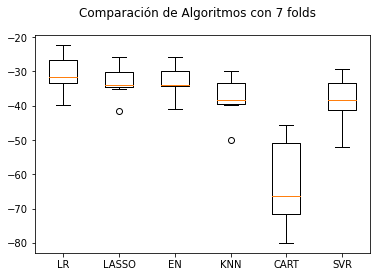

In [6]:
fig = plt.figure()
fig.suptitle('Comparación de Algoritmos con 7 folds')
ax = fig.add_subplot(111)
plt.boxplot(allresults[7])
ax.set_xticklabels(names)
plt.show()

El mejor algoritmo de momento es el LR con 7 folds para el CV

**Trabajemos ahora con una estandarización para revisar su capacidad utilizando una copia estandarizada de los datos**.

### Estandarización del dataset
Con la sospecha de que las diferentes escalas de los datos en bruto pueden afectar negativamente la capacidad de predicción de algunos de los algoritmos, evaluamos estos mismos algoritmos con una copia estandarizada del conjunto de datos. 

Es en este punto en donde los datos se transforman de tal manera que cada atributo tiene un **valor medio de 0 y una desviación estándar de 1**. 

También debemos evitar que se nos escapen datos cuando hacemos transformaciones. Una buena manera de evitarlo es usar **pipelines (tuberías)** que estandaricen los datos y construyan el modelo para cada *fold* en nuestra selección de prueba de validación cruzada. De esa manera podemos obtener una estimación justa de cómo podría funcionar cada modelo con datos estandarizados en datos no visibles.

In [7]:
# Estandarización del dataset
pipelines = []
pipelines.append(('ScLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('ScLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR(gamma='scale'))])))

allresults = {}
names = []
for nsplits in (3,5,7,10):
    print('\033[1m' + 'Precisiones con %d splits' % nsplits + '\033[0m')
    results = []
    for name, model in pipelines:
        kfold = KFold(n_splits=nsplits, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, X_train_1, y_train_1, cv=kfold, scoring='neg_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    print('--------------------------')
    allresults[nsplits] = results

Precisiones con 3 splits
ScLR: -30.779535 (2.527162)
ScLASSO: -34.231844 (3.061862)
ScEN: -32.469413 (2.595273)
ScKNN: -34.449918 (3.316046)
ScCART: -58.073207 (5.216288)
ScSVR: -31.814246 (2.305146)
--------------------------
Precisiones con 5 splits
ScLR: -30.784922 (3.910747)
ScLASSO: -34.260591 (3.262282)
ScEN: -32.582769 (3.198942)
ScKNN: -33.458248 (5.556773)
ScCART: -56.471556 (3.586327)
ScSVR: -31.473907 (3.435215)
--------------------------
Precisiones con 7 splits
ScLR: -30.488973 (5.367795)
ScLASSO: -34.005533 (6.235281)
ScEN: -32.396821 (5.800784)
ScKNN: -32.987069 (7.680175)
ScCART: -62.195656 (10.174175)
ScSVR: -31.296792 (5.947563)
--------------------------
Precisiones con 10 splits
ScLR: -30.764054 (6.105466)
ScLASSO: -34.287192 (5.035405)
ScEN: -32.552521 (5.162949)
ScKNN: -32.349421 (7.147831)
ScCART: -55.345977 (11.682323)
ScSVR: -31.440974 (6.064686)
--------------------------


No obtenemos resultados mejores

**Ahora revisamos cómo funciona si usamos una copia de los datos reescalados**

### Reescalado del dataset (entre 0 y 1)
Evaluaremos ahora los algoritmos habiendo reescalado los datos entre 0 y 1. Cuando los datos se componen de atributos con diferentes escalas, muchos algoritmos de aprendizaje automático pueden beneficiarse de volver a escalar los atributos para que todos tengan la misma escala

Usaremos igualmente pipelines (tuberías) que reescalen los datos y construyan el modelo para cada fold en nuestra selección de prueba de validación cruzada.

In [8]:
# Reescalado del dataset
pipelines = []
pipelines.append(('mMLR', Pipeline([('Scaler', MinMaxScaler()),('LR', LinearRegression())])))
pipelines.append(('mMLASSO', Pipeline([('Scaler', MinMaxScaler()),('LASSO', Lasso())])))
pipelines.append(('mMEN', Pipeline([('Scaler', MinMaxScaler()),('EN', ElasticNet())])))
pipelines.append(('mMKNN', Pipeline([('Scaler', MinMaxScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('mMCART', Pipeline([('Scaler', MinMaxScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('mMSVR', Pipeline([('Scaler', MinMaxScaler()),('SVR', SVR(gamma='scale'))])))

allresults = {}
names = []
for nsplits in (3,5,7,10):
    print('\033[1m' + 'Precisiones con %d splits' % nsplits + '\033[0m')
    results = []
    for name, model in pipelines:
        kfold = KFold(n_splits=nsplits, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, X_train_1, y_train_1, cv=kfold, scoring='neg_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    print('--------------------------')
    allresults[nsplits] = results

Precisiones con 3 splits
mMLR: -30.779535 (2.527162)
mMLASSO: -38.218334 (3.175546)
mMEN: -38.218334 (3.175546)
mMKNN: -34.336146 (3.278634)
mMCART: -58.358861 (6.756808)
mMSVR: -31.522929 (2.480197)
--------------------------
Precisiones con 5 splits
mMLR: -30.784922 (3.910747)
mMLASSO: -38.176349 (3.322022)
mMEN: -38.176349 (3.322022)
mMKNN: -33.132179 (5.066969)
mMCART: -55.616823 (1.812351)
mMSVR: -31.036212 (3.729429)
--------------------------
Precisiones con 7 splits
mMLR: -30.488973 (5.367795)
mMLASSO: -38.184250 (6.463941)
mMEN: -38.184250 (6.463941)
mMKNN: -32.791205 (6.996671)
mMCART: -63.176333 (12.265684)
mMSVR: -30.903019 (5.972852)
--------------------------
Precisiones con 10 splits
mMLR: -30.764054 (6.105466)
mMLASSO: -38.180183 (4.940528)
mMEN: -38.180183 (4.940528)
mMKNN: -32.573670 (6.484197)
mMCART: -53.555151 (10.158713)
mMSVR: -30.998492 (6.070115)
--------------------------


No obtenemos mejores resultados que en el caso anterior.

**CONCLUSIÓN: de momento el mejor modelo a usar es el algortimo LR con 7 folds y con los datos sin escalar ni estandarizar**, obteniendo un error cuadrático medio negativo de -30,489

## 1.2- Ensembles (Conjuntos)

Vamos ahora a tratar de mejorar el rendimiento de los algoritmos mediante el uso de métodos conjuntos o *ensembles*. Para ello vamos a evaluar 4 algoritmos de ML por conjuntos, 2 métodos de *boosting* o impulso y 2 de *bagging* o embolsado:

- **Métodos de *boosting* (impulso)**: AdaBoost (AB) y Gradient Boosting (GBM).
- **Métodos de *bagging* (embolsado)**: bosques aleatorios (RF) y árboles adicionales (ET).

Usaremos la misma selección de prueba que antes, validación cruzada iterando el nº de folds entre 3 y 10 , y probaremos primero sin escalar y después escalando los datos.

In [10]:
#inicialmente probamos con los datos sin escalar

ensembles = []
ensembles.append(('AB', AdaBoostRegressor()))
ensembles.append(('GBM', GradientBoostingRegressor()))
ensembles.append(('RF', RandomForestRegressor(n_estimators=100)))
ensembles.append(('ET', ExtraTreesRegressor(n_estimators=100)))

allresults = {}
names = []
for nsplits in (3,5,7,10):
    print('\033[1m' + 'Precisiones con %d splits' % nsplits + '\033[0m')
    results = []
    for name, model in ensembles:
        kfold = KFold(n_splits=nsplits, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, X_train_1, y_train_1, cv=kfold, scoring='neg_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    print('--------------------------')
    allresults[nsplits] = results

Precisiones con 3 splits
AB: -31.401649 (1.327150)
GBM: -32.262860 (3.001450)
RF: -32.032044 (3.049860)
ET: -32.067740 (3.477602)
--------------------------
Precisiones con 5 splits
AB: -32.701367 (2.905002)
GBM: -29.927790 (3.165867)
RF: -30.958979 (3.851065)
ET: -30.869209 (3.905056)
--------------------------
Precisiones con 7 splits
AB: -32.251647 (4.242367)
GBM: -29.837985 (4.417977)
RF: -30.953827 (5.610929)
ET: -30.201504 (5.487496)
--------------------------
Precisiones con 10 splits
AB: -32.185720 (5.020248)
GBM: -29.737363 (5.805503)
RF: -31.017869 (6.268347)
ET: -30.173789 (6.362879)
--------------------------


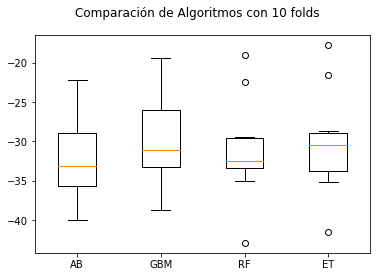

In [11]:
fig = plt.figure()
fig.suptitle('Comparación de Algoritmos con 10 folds')
ax = fig.add_subplot(111)
plt.boxplot(allresults[10])
ax.set_xticklabels(names)
plt.show()

#### Obtenemos mejores valores que con el LR solo. En concreto **el mejor valor nos lo da GradientBoostingRegressor (GBM)**, con 10 folds, teniendo un error de **-29.737**

In [12]:
#Ahora probamos estandarizando los datos

ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(n_estimators=100))])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor(n_estimators=100))])))

allresults = {}
names = []
for nsplits in (3,5,7,10):
    print('\033[1m' + 'Precisiones con %d splits' % nsplits + '\033[0m')
    results = []
    for name, model in ensembles:
        kfold = KFold(n_splits=nsplits, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, X_train_1, y_train_1, cv=kfold, scoring='neg_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    print('--------------------------')
    allresults[nsplits] = results

Precisiones con 3 splits
ScaledAB: -32.236346 (2.649786)
ScaledGBM: -32.506338 (3.306041)
ScaledRF: -31.478753 (2.897797)
ScaledET: -31.843961 (3.524068)
--------------------------
Precisiones con 5 splits
ScaledAB: -31.952094 (3.368598)
ScaledGBM: -30.154933 (3.242725)
ScaledRF: -31.418602 (4.563249)
ScaledET: -30.837282 (3.925465)
--------------------------
Precisiones con 7 splits
ScaledAB: -32.656659 (4.894224)
ScaledGBM: -29.784728 (4.468678)
ScaledRF: -31.440803 (5.071596)
ScaledET: -29.957650 (5.282013)
--------------------------
Precisiones con 10 splits
ScaledAB: -32.337904 (5.239070)
ScaledGBM: -29.807682 (5.935873)
ScaledRF: -30.981558 (6.087941)
ScaledET: -30.356712 (6.588348)
--------------------------


In [13]:
#Y probamos finalmente reescalando los datos entre 0 y 1

ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', MinMaxScaler()),('AB', AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', MinMaxScaler()),('GBM', GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', MinMaxScaler()),('RF', RandomForestRegressor(n_estimators=100))])))
ensembles.append(('ScaledET', Pipeline([('Scaler', MinMaxScaler()),('ET', ExtraTreesRegressor(n_estimators=100))])))

allresults = {}
names = []
for nsplits in (3,5,7,10):
    print('\033[1m' + 'Precisiones con %d splits' % nsplits + '\033[0m')
    results = []
    for name, model in ensembles:
        kfold = KFold(n_splits=nsplits, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, X_train_1, y_train_1, cv=kfold, scoring='neg_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    print('--------------------------')
    allresults[nsplits] = results

Precisiones con 3 splits
ScaledAB: -32.190639 (1.365306)
ScaledGBM: -32.128736 (3.146807)
ScaledRF: -30.988036 (2.261074)
ScaledET: -32.097651 (3.967357)
--------------------------
Precisiones con 5 splits
ScaledAB: -32.094173 (2.608818)
ScaledGBM: -30.155323 (3.285362)
ScaledRF: -31.297504 (4.208727)
ScaledET: -30.965862 (4.228829)
--------------------------
Precisiones con 7 splits
ScaledAB: -31.741610 (4.588213)
ScaledGBM: -29.653566 (4.294439)
ScaledRF: -30.904061 (5.479067)
ScaledET: -30.653357 (5.173060)
--------------------------
Precisiones con 10 splits
ScaledAB: -31.990396 (5.679825)
ScaledGBM: -29.651785 (5.915373)
ScaledRF: -30.578473 (6.067837)
ScaledET: -30.172819 (6.707073)
--------------------------


Observamos que obtenemos mejores resultados con los datos reescalados, con el GBM con 10 folds, por lo que:

#### **CONCLUSIÓN: el mejor modelo obtenido finalmente en el caso 1 (con seleccion de 5 características para NO2) es el ensemble GradientBoostingRegressor (GBM) con 10 folds y con los datos reescalados, obteniendo un error cuadrático medio negativo de -29.652**

---------------------------------------------------------------------------------------------------------------------


## 2) Carga del dataset mergeado trabajado CON selección de características PCA

Ahora vamos a realizar el mismo estudio pero cogiendo el dataset trabajado con selección de características mediante PCA, para comprobar si los resultados son mejores o peores


In [14]:
#cogemos el dataset trabajado anteriormente con los datos mergeados y habiendo hecho una reducción de variables
url_fichero_mercscpca = './DatosMergeadosBarcelona_ConSeleccionCaract_PCA.csv'
dfMergeadoSelCaractPCA = pd.read_csv(url_fichero_mercscpca)
dfMergeadoSelCaractPCA = dfMergeadoSelCaractPCA.set_index('date')
print(dfMergeadoSelCaractPCA.columns)
print(dfMergeadoSelCaractPCA)

Index(['pm10', 'no2', 'year', 'month', 'day', 'week', 'season', 'season_name',
       'diadelasemana', 'findesemana', 'PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5'],
      dtype='object')
                 pm10        no2  year  month  day  week  season season_name  \
date                                                                           
2018-01-01  10.000000  24.000000  2018      1    1     1       1      Winter   
2018-01-02  11.000000  10.000000  2018      1    2     1       1      Winter   
2018-01-03  10.000000   7.000000  2018      1    3     1       1      Winter   
2018-01-04  11.000000  14.000000  2018      1    4     1       1      Winter   
2018-01-05  10.000000  20.000000  2018      1    5     1       1      Winter   
...               ...        ...   ...    ...  ...   ...     ...         ...   
2019-12-27  16.000000  18.000000  2019     12   27    52       1      Winter   
2019-12-28  19.000000  16.000000  2019     12   28    52       1      Winter   
2019-12-29  23.0000

In [15]:
#Eliminamos todos los campos que no son de meteorología o de tráfico (los que son de fechas)
dfMergeadoSelCaractPCA = dfMergeadoSelCaractPCA.drop(columns=['year','month','day','week','season','season_name','diadelasemana',
       'findesemana'])
print(dfMergeadoSelCaractPCA.columns)

Index(['pm10', 'no2', 'PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5'], dtype='object')


## 2.1- Evaluación de los algoritmos
### Dataset de validación de división (Split-out)
**Dejaremos 80-20, preparado para CV de 10-folds** 

Vamos a separar el dataset en un 80 (train) - 20 (validation). Con el de 80 (train) haremos validación cruzada, y con el de 20 haremos la validación final.


In [17]:
array2 = dfMergeadoSelCaractPCA.values
X_2 = array2[:,2:]
y = array2[:,1]
validation_size = 0.20
seed = 7
X_train_2, X_validation_2, y_train_2, y_validation_2 = train_test_split(X_2, y, test_size=validation_size, random_state=seed)
print('X_Train_2: ', X_train_2.shape)
print('X_Validation_2: ', X_validation_2.shape)

X_Train_2:  (584, 5)
X_Validation_2:  (146, 5)


Igualmente vamos a probar los siguientes algoritmos de clasificación:

- Regresión lineal (LR)
- Regularización de Regresión Lasso (L1)(LASSO)
- Regularización de Regresión ElasticNet (EN)
- k-vecinos más cercanos (KNN)
- Árboles de decisión de regresión (CART)
- Regresión de vectores de soporte (SVR)

Usaremos la validación cruzada de nuevo probando con diversos nº de folds entre 3 y 10 y mediremos la precisión de los algoritmos mediante la métrica 'neg_mean_squared_error'

**Inicialmente vamos a probar los algoritmos sobre los datos sin ningún preprocesamiento: no les hemos estandarizado ni reescalado.**

In [18]:
## Algoritmos de control/Test puntual. Usaremos 6 tipos:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR(gamma='scale')))

#En un diccionario 'allresults' vamos guardando los resultados de los modelos para los diversos cv con 3,5,7 y 10 folds

allresults = {}
names = []
for nsplits in (3,5,7,10):
    print('\033[1m' + 'Precisiones con %d splits' % nsplits + '\033[0m')
    results = []
    for name, model in models:
        kfold = KFold(n_splits=nsplits, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, X_train_2, y_train_2, cv=kfold, scoring='neg_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    print('--------------------------')
    allresults[nsplits] = results

Precisiones con 3 splits
LR: -32.968542 (1.879084)
LASSO: -33.037678 (1.946317)
EN: -32.976754 (1.885081)
KNN: -37.391182 (0.909715)
CART: -67.264670 (6.059491)
SVR: -33.254805 (1.565960)
--------------------------
Precisiones con 5 splits
LR: -33.206282 (2.772036)
LASSO: -33.284872 (2.728132)
EN: -33.212434 (2.743736)
KNN: -37.487933 (2.147921)
CART: -61.911813 (10.420077)
SVR: -33.707674 (2.069732)
--------------------------
Precisiones con 7 splits
LR: -32.804662 (4.212112)
LASSO: -32.918460 (4.476565)
EN: -32.842521 (4.390876)
KNN: -36.719983 (4.399487)
CART: -64.119244 (10.233572)
SVR: -33.369949 (5.192667)
--------------------------
Precisiones con 10 splits
LR: -32.934381 (5.039883)
LASSO: -33.054292 (4.842167)
EN: -32.969938 (4.920993)
KNN: -37.349894 (6.039831)
CART: -68.894932 (12.454204)
SVR: -33.128739 (4.873216)
--------------------------


**Trabajemos ahora con una estandarización para revisar su capacidad utilizando una copia estandarizada de los datos.**

### Estandarización del dataset

In [19]:
# Estandarización del dataset
pipelines = []
pipelines.append(('ScLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('ScLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR(gamma='scale'))])))

allresults = {}
names = []
for nsplits in (3,5,7,10):
    print('\033[1m' + 'Precisiones con %d splits' % nsplits + '\033[0m')
    results = []
    for name, model in pipelines:
        kfold = KFold(n_splits=nsplits, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, X_train_2, y_train_2, cv=kfold, scoring='neg_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    print('--------------------------')
    allresults[nsplits] = results

Precisiones con 3 splits
ScLR: -32.968542 (1.879084)
ScLASSO: -36.098912 (3.160829)
ScEN: -34.655051 (2.731907)
ScKNN: -35.448754 (1.985013)
ScCART: -67.379770 (8.341734)
ScSVR: -33.244498 (1.976517)
--------------------------
Precisiones con 5 splits
ScLR: -33.206282 (2.772036)
ScLASSO: -36.098650 (3.113716)
ScEN: -34.832459 (2.859580)
ScKNN: -36.165546 (2.243864)
ScCART: -61.643213 (8.951438)
ScSVR: -33.626336 (2.322141)
--------------------------
Precisiones con 7 splits
ScLR: -32.804662 (4.212112)
ScLASSO: -36.001357 (5.956920)
ScEN: -34.675817 (5.437499)
ScKNN: -35.309749 (4.311212)
ScCART: -62.663628 (8.792635)
ScSVR: -33.527985 (5.277134)
--------------------------
Precisiones con 10 splits
ScLR: -32.934381 (5.039883)
ScLASSO: -36.073917 (4.754207)
ScEN: -34.752667 (4.617366)
ScKNN: -36.972757 (7.110481)
ScCART: -67.697097 (13.348153)
ScSVR: -33.432634 (5.143130)
--------------------------


**Finalmente revisamos cómo funciona si usamos una copia de los datos reescalados**

### Reescalado del dataset (entre 0 y 1)

In [20]:
# Reescalado del dataset
pipelines = []
pipelines.append(('mMLR', Pipeline([('Scaler', MinMaxScaler()),('LR', LinearRegression())])))
pipelines.append(('mMLASSO', Pipeline([('Scaler', MinMaxScaler()),('LASSO', Lasso())])))
pipelines.append(('mMEN', Pipeline([('Scaler', MinMaxScaler()),('EN', ElasticNet())])))
pipelines.append(('mMKNN', Pipeline([('Scaler', MinMaxScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('mMCART', Pipeline([('Scaler', MinMaxScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('mMSVR', Pipeline([('Scaler', MinMaxScaler()),('SVR', SVR(gamma='scale'))])))

allresults = {}
names = []
for nsplits in (3,5,7,10):
    print('\033[1m' + 'Precisiones con %d splits' % nsplits + '\033[0m')
    results = []
    for name, model in pipelines:
        kfold = KFold(n_splits=nsplits, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, X_train_2, y_train_2, cv=kfold, scoring='neg_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    print('--------------------------')
    allresults[nsplits] = results

Precisiones con 3 splits
mMLR: -32.968542 (1.879084)
mMLASSO: -38.218334 (3.175546)
mMEN: -38.218334 (3.175546)
mMKNN: -35.396585 (0.831898)
mMCART: -67.616117 (5.923016)
mMSVR: -33.102964 (1.857530)
--------------------------
Precisiones con 5 splits
mMLR: -33.206282 (2.772036)
mMLASSO: -38.176349 (3.322022)
mMEN: -38.176349 (3.322022)
mMKNN: -35.810660 (2.781379)
mMCART: -64.133283 (9.655820)
mMSVR: -33.483572 (2.317882)
--------------------------
Precisiones con 7 splits
mMLR: -32.804662 (4.212112)
mMLASSO: -38.184250 (6.463941)
mMEN: -38.184250 (6.463941)
mMKNN: -34.446300 (3.706507)
mMCART: -61.019732 (7.587375)
mMSVR: -33.383832 (5.176387)
--------------------------
Precisiones con 10 splits
mMLR: -32.934381 (5.039883)
mMLASSO: -38.180183 (4.940528)
mMEN: -38.180183 (4.940528)
mMKNN: -36.105397 (6.723954)
mMCART: -67.340244 (12.630542)
mMSVR: -33.353786 (5.003523)
--------------------------


**Ninguno de todos estos valores es mejor que los obtenidos con los datos con la selección de variables para NO2**

## 2.2- Ensembles (Conjuntos)

Podemos probar los mismos ensembles de antes, aunque ya imaginamos que no obtendremos resultados mejores

In [21]:
#inicialmente probamos con los datos sin escalar

ensembles = []
ensembles.append(('AB', AdaBoostRegressor()))
ensembles.append(('GBM', GradientBoostingRegressor()))
ensembles.append(('RF', RandomForestRegressor(n_estimators=100)))
ensembles.append(('ET', ExtraTreesRegressor(n_estimators=100)))

allresults = {}
names = []
for nsplits in (3,5,7,10):
    print('\033[1m' + 'Precisiones con %d splits' % nsplits + '\033[0m')
    results = []
    for name, model in ensembles:
        kfold = KFold(n_splits=nsplits, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, X_train_2, y_train_2, cv=kfold, scoring='neg_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    print('--------------------------')
    allresults[nsplits] = results

Precisiones con 3 splits
AB: -34.420650 (0.741016)
GBM: -34.405699 (1.455274)
RF: -33.940522 (0.715037)
ET: -35.323599 (0.657719)
--------------------------
Precisiones con 5 splits
AB: -33.236744 (1.830777)
GBM: -34.757396 (2.528374)
RF: -33.995980 (2.004488)
ET: -35.753466 (3.219441)
--------------------------
Precisiones con 7 splits
AB: -33.558501 (4.538780)
GBM: -33.684995 (3.719457)
RF: -33.611951 (3.919432)
ET: -34.961290 (3.899344)
--------------------------
Precisiones con 10 splits
AB: -33.490058 (5.063512)
GBM: -34.419995 (6.420231)
RF: -34.497742 (6.368410)
ET: -35.156033 (7.120828)
--------------------------


In [22]:
#Ahora probamos estandarizando los datos

ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(n_estimators=100))])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor(n_estimators=100))])))

allresults = {}
names = []
for nsplits in (3,5,7,10):
    print('\033[1m' + 'Precisiones con %d splits' % nsplits + '\033[0m')
    results = []
    for name, model in ensembles:
        kfold = KFold(n_splits=nsplits, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, X_train_2, y_train_2, cv=kfold, scoring='neg_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    print('--------------------------')
    allresults[nsplits] = results

Precisiones con 3 splits
ScaledAB: -34.415184 (1.059335)
ScaledGBM: -34.145136 (1.365256)
ScaledRF: -33.749428 (0.547628)
ScaledET: -36.208042 (0.949637)
--------------------------
Precisiones con 5 splits
ScaledAB: -34.307027 (1.706717)
ScaledGBM: -34.628863 (2.470766)
ScaledRF: -34.551174 (1.653311)
ScaledET: -35.333317 (2.405425)
--------------------------
Precisiones con 7 splits
ScaledAB: -33.759816 (4.607318)
ScaledGBM: -33.711719 (3.769649)
ScaledRF: -33.566425 (4.169349)
ScaledET: -34.758925 (4.264812)
--------------------------
Precisiones con 10 splits
ScaledAB: -33.960670 (5.381946)
ScaledGBM: -34.369928 (6.313592)
ScaledRF: -33.775723 (6.026115)
ScaledET: -34.844889 (6.912646)
--------------------------


Efectivamente no conseguimos mejores resultados que con la anterior selección de características. Por tanto:

## Conclusión:
**El mejor modelo obtenido sigue siendo el ensemble GradientBoostingRegressor (GBM) con validación cruzada de 10 folds, habiendo realizado una selección de 5 características y con los datos reescalados, obteniendo un error cuadrático medio negativo de -29.652**

---------------------------------------------------------------------------------------------------------------------


## 3) Carga del dataset mergeado trabajado SIN selección de características para NO2

Ahora vamos a realizar el mismo estudio pero cogiendo el dataset trabajado sin selección de características, para comprobar si los resultados son mejores o peores


In [23]:
#cogemos el dataset trabajado anteriormente con los datos mergeados sin haber hecho una reducción de variables
url_fichero_merssc = './DatosMergeadosBarcelona.csv'
dfMergeado = pd.read_csv(url_fichero_merssc)
dfMergeado = dfMergeado.set_index('date')
print(dfMergeado.columns)
print(dfMergeado)

Index(['pm10', 'no2', 'year', 'month', 'day', 'tmed', 'prec', 'tmin', 'tmax',
       'dir', 'velmedia', 'racha', 'sol', 'presmax', 'presmin', 'week',
       'season', 'season_name', 'estado_trafico', 'diadelasemana',
       'findesemana'],
      dtype='object')
                 pm10        no2  year  month  day  tmed  prec  tmin  tmax  \
date                                                                         
2018-01-01  10.000000  24.000000  2018      1    1  12.8   0.0  10.2  10.2   
2018-01-02  11.000000  10.000000  2018      1    2  14.6   0.0  11.4  11.4   
2018-01-03  10.000000   7.000000  2018      1    3  17.9   0.0  14.0  14.0   
2018-01-04  11.000000  14.000000  2018      1    4  19.2   0.0  16.4  16.4   
2018-01-05  10.000000  20.000000  2018      1    5  16.4   0.0  13.7  13.7   
...               ...        ...   ...    ...  ...   ...   ...   ...   ...   
2019-12-27  16.000000  18.000000  2019     12   27  12.0   0.0   8.5   8.5   
2019-12-28  19.000000  16.000000  20

In [24]:
#Eliminamos todos los campos que no son de meteorología o de tráfico (los que son de fechas)
dfMergeado = dfMergeado.drop(columns=['year','month','day','week','season','season_name','diadelasemana',
       'findesemana'])
print(dfMergeado.columns)

Index(['pm10', 'no2', 'tmed', 'prec', 'tmin', 'tmax', 'dir', 'velmedia',
       'racha', 'sol', 'presmax', 'presmin', 'estado_trafico'],
      dtype='object')


## 3.1- Evaluación de los algoritmos
### Dataset de validación de división (Split-out)
**Dejaremos 80-20, preparado para CV de 10-folds** 

Vamos a separar el dataset en un 80 (train) - 20 (validation). Con el de 80 (train) haremos validación cruzada, y con el de 20 haremos la validación final.


In [25]:
array3 = dfMergeado.values
X_3 = array3[:,2:]
y = array3[:,1]
validation_size = 0.20
seed = 7
X_train_3, X_validation_3, y_train_3, y_validation_3 = train_test_split(X_3, y, test_size=validation_size, random_state=seed)
print('X_Train_3: ', X_train_3.shape)
print('X_Validation_3: ', X_validation_3.shape)

X_Train_3:  (584, 11)
X_Validation_3:  (146, 11)


Igualmente vamos a probar los siguientes algoritmos de clasificación:

- Regresión lineal (LR)
- Regularización de Regresión Lasso (L1)(LASSO)
- Regularización de Regresión ElasticNet (EN)
- k-vecinos más cercanos (KNN)
- Árboles de decisión de regresión (CART)
- Regresión de vectores de soporte (SVR)

Usaremos la validación cruzada de nuevo probando con diversos nº de folds entre 3 y 10 y mediremos la precisión de los algoritmos mediante la métrica 'neg_mean_squared_error'

**Inicialmente vamos a probar los algoritmos sobre los datos sin ningún preprocesamiento: no les hemos estandarizado ni reescalado.**

In [26]:
## Algoritmos de control/Test puntual. Usaremos 6 tipos:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR(gamma='scale')))

#En un diccionario 'allresults' vamos guardando los resultados de los modelos para los diversos cv con 3,5,7 y 10 folds

allresults = {}
names = []
for nsplits in (3,5,7,10):
    print('\033[1m' + 'Precisiones con %d splits' % nsplits + '\033[0m')
    results = []
    for name, model in models:
        kfold = KFold(n_splits=nsplits, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, X_train_3, y_train_3, cv=kfold, scoring='neg_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    print('--------------------------')
    allresults[nsplits] = results

Precisiones con 3 splits
LR: -30.341336 (3.290981)
LASSO: -32.285523 (1.806967)
EN: -32.168451 (1.803811)
KNN: -35.084229 (1.700378)
CART: -60.459497 (0.855999)
SVR: -38.333008 (2.981362)
--------------------------
Precisiones con 5 splits
LR: -30.538431 (3.599254)
LASSO: -32.602406 (2.825201)
EN: -32.441872 (2.632521)
KNN: -35.493400 (4.177003)
CART: -57.873026 (2.935296)
SVR: -38.270435 (3.360004)
--------------------------
Precisiones con 7 splits
LR: -29.990089 (5.671678)
LASSO: -32.245376 (4.568467)
EN: -32.022553 (4.327241)
KNN: -34.791413 (6.029833)
CART: -56.433274 (6.301331)
SVR: -38.377589 (6.977450)
--------------------------
Precisiones con 10 splits
LR: -30.095427 (5.626259)
LASSO: -32.291902 (4.628354)
EN: -32.124972 (4.619121)
KNN: -35.040076 (6.815377)
CART: -66.155045 (10.704065)
SVR: -38.289293 (5.514200)
--------------------------


**Trabajemos ahora con una estandarización para revisar su capacidad utilizando una copia estandarizada de los datos**.

### Estandarización del dataset

In [27]:
# Estandarización del dataset
pipelines = []
pipelines.append(('ScLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('ScLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR(gamma='scale'))])))

allresults = {}
names = []
for nsplits in (3,5,7,10):
    print('\033[1m' + 'Precisiones con %d splits' % nsplits + '\033[0m')
    results = []
    for name, model in pipelines:
        kfold = KFold(n_splits=nsplits, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, X_train_3, y_train_3, cv=kfold, scoring='neg_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    print('--------------------------')
    allresults[nsplits] = results

Precisiones con 3 splits
ScLR: -30.341336 (3.290981)
ScLASSO: -33.807702 (2.962139)
ScEN: -31.888402 (2.479627)
ScKNN: -32.837768 (2.982163)
ScCART: -56.655587 (3.797580)
ScSVR: -30.669460 (1.981478)
--------------------------
Precisiones con 5 splits
ScLR: -30.538431 (3.599254)
ScLASSO: -33.950611 (3.320366)
ScEN: -32.091908 (3.324794)
ScKNN: -33.617472 (2.655968)
ScCART: -56.971457 (3.297314)
ScSVR: -31.049841 (2.700430)
--------------------------
Precisiones con 7 splits
ScLR: -29.990089 (5.671678)
ScLASSO: -33.653898 (6.274859)
ScEN: -31.903649 (5.782606)
ScKNN: -31.895454 (6.250493)
ScCART: -57.342376 (8.332564)
ScSVR: -30.774451 (5.840736)
--------------------------
Precisiones con 10 splits
ScLR: -30.095427 (5.626259)
ScLASSO: -33.903404 (5.028003)
ScEN: -32.041005 (5.209035)
ScKNN: -32.211487 (7.138386)
ScCART: -65.595063 (13.129110)
ScSVR: -30.668673 (5.607727)
--------------------------


**Finalmente revisamos cómo funciona si usamos una copia de los datos reescalados**

### Reescalado del dataset (entre 0 y 1)

In [28]:
# Reescalado del dataset
pipelines = []
pipelines.append(('mMLR', Pipeline([('Scaler', MinMaxScaler()),('LR', LinearRegression())])))
pipelines.append(('mMLASSO', Pipeline([('Scaler', MinMaxScaler()),('LASSO', Lasso())])))
pipelines.append(('mMEN', Pipeline([('Scaler', MinMaxScaler()),('EN', ElasticNet())])))
pipelines.append(('mMKNN', Pipeline([('Scaler', MinMaxScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('mMCART', Pipeline([('Scaler', MinMaxScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('mMSVR', Pipeline([('Scaler', MinMaxScaler()),('SVR', SVR(gamma='scale'))])))

allresults = {}
names = []
for nsplits in (3,5,7,10):
    print('\033[1m' + 'Precisiones con %d splits' % nsplits + '\033[0m')
    results = []
    for name, model in pipelines:
        kfold = KFold(n_splits=nsplits, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, X_train_3, y_train_3, cv=kfold, scoring='neg_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    print('--------------------------')
    allresults[nsplits] = results

Precisiones con 3 splits
mMLR: -30.341336 (3.290981)
mMLASSO: -38.218334 (3.175546)
mMEN: -38.218334 (3.175546)
mMKNN: -32.657866 (2.645055)
mMCART: -59.113809 (1.703948)
mMSVR: -30.689464 (2.144534)
--------------------------
Precisiones con 5 splits
mMLR: -30.538431 (3.599254)
mMLASSO: -38.176349 (3.322022)
mMEN: -38.176349 (3.322022)
mMKNN: -33.439794 (4.373502)
mMCART: -55.099840 (4.286241)
mMSVR: -31.118857 (3.242354)
--------------------------
Precisiones con 7 splits
mMLR: -29.990089 (5.671678)
mMLASSO: -38.184250 (6.463941)
mMEN: -38.184250 (6.463941)
mMKNN: -32.535983 (7.519647)
mMCART: -55.450711 (8.345408)
mMSVR: -30.908069 (6.289142)
--------------------------
Precisiones con 10 splits
mMLR: -30.095427 (5.626259)
mMLASSO: -38.180183 (4.940528)
mMEN: -38.180183 (4.940528)
mMKNN: -33.155643 (7.980772)
mMCART: -64.603970 (12.982818)
mMSVR: -30.732908 (5.529195)
--------------------------


**Ninguno de todos estos valores es mejor que los obtenidos en el primer caso**

## 3.2- Ensembles (Conjuntos)

Podemos probar los mismos ensembles de antes.

In [29]:
#inicialmente probamos con los datos sin escalar

ensembles = []
ensembles.append(('AB', AdaBoostRegressor()))
ensembles.append(('GBM', GradientBoostingRegressor()))
ensembles.append(('RF', RandomForestRegressor(n_estimators=100)))
ensembles.append(('ET', ExtraTreesRegressor(n_estimators=100)))

allresults = {}
names = []
for nsplits in (3,5,7,10):
    print('\033[1m' + 'Precisiones con %d splits' % nsplits + '\033[0m')
    results = []
    for name, model in ensembles:
        kfold = KFold(n_splits=nsplits, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, X_train_3, y_train_3, cv=kfold, scoring='neg_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    print('--------------------------')
    allresults[nsplits] = results

Precisiones con 3 splits
AB: -30.552563 (1.681326)
GBM: -32.215168 (0.982507)
RF: -30.920280 (2.022447)
ET: -29.879461 (2.956388)
--------------------------
Precisiones con 5 splits
AB: -32.358948 (3.849457)
GBM: -30.421322 (2.231318)
RF: -30.275198 (3.978965)
ET: -30.345797 (3.505337)
--------------------------
Precisiones con 7 splits
AB: -31.067891 (4.938095)
GBM: -30.271654 (3.895651)
RF: -29.559337 (4.838741)
ET: -29.289769 (5.084663)
--------------------------
Precisiones con 10 splits
AB: -31.585140 (6.062872)
GBM: -29.360865 (6.106911)
RF: -29.883951 (5.916195)
ET: -29.605763 (5.604723)
--------------------------


In [30]:
#Ahora probamos estandarizando los datos

ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(n_estimators=100))])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor(n_estimators=100))])))

allresults = {}
names = []
for nsplits in (3,5,7,10):
    print('\033[1m' + 'Precisiones con %d splits' % nsplits + '\033[0m')
    results = []
    for name, model in ensembles:
        kfold = KFold(n_splits=nsplits, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, X_train_3, y_train_3, cv=kfold, scoring='neg_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    print('--------------------------')
    allresults[nsplits] = results

Precisiones con 3 splits
ScaledAB: -31.996093 (2.045901)
ScaledGBM: -32.112500 (1.030264)
ScaledRF: -31.467439 (1.769176)
ScaledET: -30.553310 (2.727274)
--------------------------
Precisiones con 5 splits
ScaledAB: -31.987030 (2.638307)
ScaledGBM: -30.420131 (2.305778)
ScaledRF: -30.924397 (3.436547)
ScaledET: -30.058119 (3.112675)
--------------------------
Precisiones con 7 splits
ScaledAB: -32.011100 (5.238032)
ScaledGBM: -30.274637 (3.823123)
ScaledRF: -29.815928 (4.511272)
ScaledET: -28.901358 (5.369499)
--------------------------
Precisiones con 10 splits
ScaledAB: -31.853445 (6.056951)
ScaledGBM: -29.279941 (6.056855)
ScaledRF: -29.943707 (6.467730)
ScaledET: -29.311172 (5.908387)
--------------------------


In [31]:
#Y probamos finalmente reescalando los datos entre 0 y 1

ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', MinMaxScaler()),('AB', AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', MinMaxScaler()),('GBM', GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', MinMaxScaler()),('RF', RandomForestRegressor(n_estimators=100))])))
ensembles.append(('ScaledET', Pipeline([('Scaler', MinMaxScaler()),('ET', ExtraTreesRegressor(n_estimators=100))])))

allresults = {}
names = []
for nsplits in (3,5,7,10):
    print('\033[1m' + 'Precisiones con %d splits' % nsplits + '\033[0m')
    results = []
    for name, model in ensembles:
        kfold = KFold(n_splits=nsplits, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, X_train_3, y_train_3, cv=kfold, scoring='neg_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    print('--------------------------')
    allresults[nsplits] = results

Precisiones con 3 splits
ScaledAB: -31.773228 (1.249348)
ScaledGBM: -32.083717 (1.175042)
ScaledRF: -30.416676 (2.330039)
ScaledET: -29.810521 (3.454755)
--------------------------
Precisiones con 5 splits
ScaledAB: -31.716579 (3.311365)
ScaledGBM: -30.209462 (2.336992)
ScaledRF: -30.594336 (3.675830)
ScaledET: -30.059222 (2.730079)
--------------------------
Precisiones con 7 splits
ScaledAB: -31.114270 (5.469521)
ScaledGBM: -30.350896 (3.915681)
ScaledRF: -29.809279 (5.041035)
ScaledET: -29.280431 (5.245424)
--------------------------
Precisiones con 10 splits
ScaledAB: -32.030397 (5.927186)
ScaledGBM: -29.264438 (6.118589)
ScaledRF: -29.500202 (5.722423)
ScaledET: -28.991327 (5.688172)
--------------------------


Obtenemos **un mejor valor** con el ET con 10 folds **con los datos reescalados sin selección de características** que con selección de características. 

## Resumen:
- Con Seleccion Caracteristicas NO2
    - Sin escalado: LR 7 folds (30.489)
    - Estandarizando: no mejora
    - Reescalando: no mejora

    Ensembles:
    - Sin escalado: GBM 10 folds (29.737)
    - Estandarizando: no mejora
    - Reescalando: GBM 10 folds (29.652)

- Con Seleccion Caracteristicas PCA

    Nada mejora

- Sin Seleccion Caracteristicas
    - Sin escalado: no mejora
    - Estandarizando: no mejora
    - Reescalando: no mejora

    Ensembles:
    - Sin escalado: ET 7 folds (29.29)
    - Estandarizando: GBM 10 folds (29.28)
    - Reescalando: ET 10 folds (28.991)

## Conclusión:
#### **El mejor modelo obtenido es el ensemble ExtraTreesRegressor (ET) con validación cruzada de 10 folds, sin reducción de características y con los datos reescalados entre 0 y 1, obteniendo un error cuadrático medio negativo de -28.991**

## 3.3- Tunning del ExtraTreeRegressor
Cogiendo de nuevo el dataset sin selección de características, y el modelo ExtraTreesRegressor (ET) con los datos reescalados, vamos a probar a mejorarlo ajustando su número de Estimadores, para ver si obtenemos mejor puntuación con algún número distinto de 100.

In [32]:
for num_estimators in (50,100,150,200,250,300,350,400):
    model=Pipeline([('Scaler', MinMaxScaler()),('ET', ExtraTreesRegressor(n_estimators=num_estimators))])
    kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train_3, y_train_3, cv=kfold, scoring='neg_mean_squared_error')
    print("%f (%f) with n_estimators: %r" % (cv_results.mean(), cv_results.std(), num_estimators))

-29.149809 (5.484566) with n_estimators: 50
-28.993648 (5.368289) with n_estimators: 100
-28.905066 (5.636153) with n_estimators: 150
-28.739953 (5.206112) with n_estimators: 200
-28.660213 (5.199614) with n_estimators: 250
-28.887963 (5.517956) with n_estimators: 300
-28.869632 (5.414241) with n_estimators: 350
-28.622275 (5.568562) with n_estimators: 400


### Mejoramos el modelo con 400 estimadores.

# 4) Finalizar el modelo
## Predicciones sobre el conjunto de datos de validación

In [33]:
## Preparamos el modelo y lo entrenamos sobre el dataset de entrenamiento
## cogiendo el dataset sin selección de características

array = dfMergeado.values
X = array[:,2:]
y = array[:,1]
validation_size = 0.20
seed = 7
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=validation_size, random_state=seed)

model=Pipeline([('Scaler', MinMaxScaler()),('ET', ExtraTreesRegressor(n_estimators=400))])
model.fit(X_train, y_train)

Pipeline(steps=[('Scaler', MinMaxScaler()),
                ('ET', ExtraTreesRegressor(n_estimators=400))])

In [34]:
### Aplicamos predicciones sobre el dataset de validación y obtenemos su error cuadrático medio

predicciones = model.predict(X_validation)
print(mean_squared_error(y_validation, predicciones))

32.02154830740475


Vamos a pintar los datos NO2 de validación junto a las predicciones realizadas por nuestro algoritmo

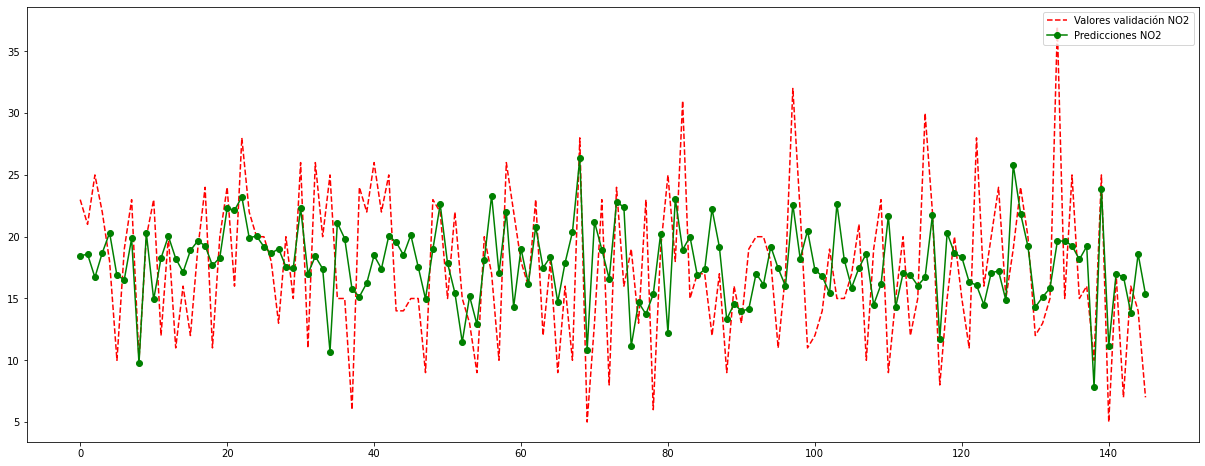

In [35]:
plt.figure(figsize=(21, 8))

grafica = plt.plot(y_validation,'--r',predicciones,'-og')
plt.legend(('Valores validación NO2', 'Predicciones NO2'),
           loc='upper right')
plt.show;

## 5) Guardado del modelo

In [36]:
#Entrenamos el modelo con el dataset completo

array = dfMergeado.values
X = array[:,2:]
y = array[:,1]

model=Pipeline([('Scaler', MinMaxScaler()),('ET', ExtraTreesRegressor(n_estimators=400))])
model.fit(X, y)

Pipeline(steps=[('Scaler', MinMaxScaler()),
                ('ET', ExtraTreesRegressor(n_estimators=400))])

In [37]:
#Guardamos el modelo usando la biblioteca Joblib

fichero_modeloJoblib = 'Modelo_finalizado_BarcelonaNO2.sav'
dump(model, fichero_modeloJoblib)

['Modelo_finalizado_BarcelonaNO2.sav']